# IPA to IMAGE model

## Prerequisites

In principle, this should work on a computer without a GPU. It will help if you have a lot of RAM.

- Install the latest versions of the following Python modules:
   - https://github.com/gchrupala/funktional
   - https://github.com/gchrupala/reimaginet
- Download http://grzegorz.chrupala.me/data/coco.zip and unzip it in the `reimaginet/data/coco directory`.
  You should have the following files:
  
  - `dataset.json` - MSCOCO sentences
  - `vgg_feats.mat` - MSCOCO image vectors
  - `dataset.ipa.jsonl.gz`  - IPA transcriptions of MSCOCO sentences

- (Copy pretrained models from `yellow.uvt.nl:/home/gchrupala/repos/reimaginet/examples/vis` and `yellow.uvt.nl:/home/gchrupala/repos/reimaginet/examples/vis/lm`)

In [3]:
import imaginet.defn.visual as visual
import imaginet.task

## Load the model

(It will take a couple of minutes)

In [5]:
model = imaginet.task.load(path="vis/model.10.zip")

## Symbol embeddings

In [8]:
reload(visual)
emb = visual.embeddings(model)
print(emb.shape)

(65, 256)


The table of IPA symbols corresponding to  the 49 dimensions 

In [9]:
symb = visual.symbols(model)
print " ".join(symb.values())

<BEG> <END> <UNK> t uː w ɪ m n ɑː l ʊ k ŋ a ð eə s ɛ f əʊ z ɐ ɹ ə dʒ eɪ p d ɔː aɪ ʃ ɒ v ɔɪ ʌ b i θ iː aʊ h ɜː tʃ j əl iːː ɡ iə ʊə aɪə ʒ aʊə r ɑ̃ t
 ə
 z
 s
 n
 nʲ d
 ŋ
 ɔ m



Let's display the embeddings projected to 2D via PCA

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


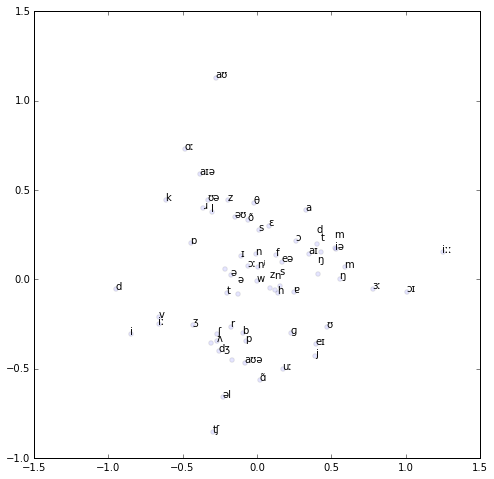

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xy = pca.fit_transform(emb)
pylab.rc('font', family='DejaVu Sans')
pylab.figure(figsize=(8,8))
pylab.scatter(xy[:,0], xy[:,1], alpha=0.1)
for j,symb_j in symb.items():
    if symb_j not in ["<BEG>","<END>", "<UNK>"]:
        pylab.text(xy[j,0], xy[j,1], symb_j)

Seems mostly random...

Let's try the same with a Language Model.

### Symbol embeddings for a language model

In [24]:
import imaginet.defn.lm
reload(imaginet.defn.lm)
model2 = imaginet.task.load("lm/model.10.zip")
emb2 = imaginet.defn.lm.embeddings(model2)

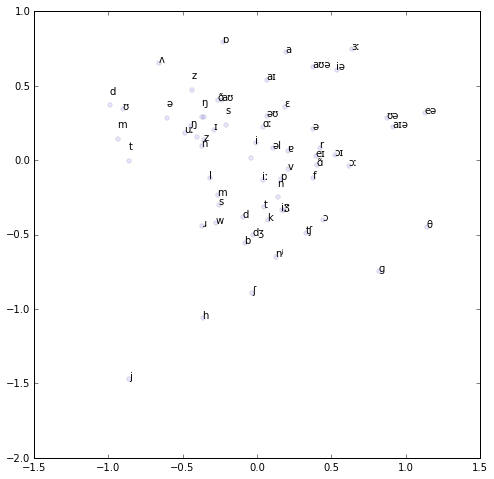

In [25]:
pca2 = PCA(n_components=2)
xy = pca.fit_transform(emb2)
pylab.rc('font', family='DejaVu Sans')
pylab.figure(figsize=(8,8))
pylab.scatter(xy[:,0], xy[:,1], alpha=0.1)
for j,symb_j in symb.items(): 
    if symb_j not in ["<BEG>","<END>", "<UNK>"]:
        pylab.text(xy[j,0], xy[j,1], symb_j)

There is clear structure in the embeddings for the LM model.

## Load MSCOCO validation data

In [26]:
from imaginet.data_provider import getDataProvider
# Adjust the root to point to the directory above data
prov = getDataProvider('coco', root="..")

In [27]:
sents = list(prov.iterSentences(split='val'))

In [28]:
from imaginet.simple_data import phonemes
sents_ipa = [ phonemes(sent) for sent in sents ]

## Project sentences to state space

In [29]:
reps = imaginet.task.representation(model, sents_ipa)

## Find similar sentences in state space

Compute the pairwise cosine distance matrix.

In [30]:
from scipy.spatial.distance import cdist
distance = cdist(reps, reps, metric='cosine')

### Display neighbors for a sentence

In [31]:
import numpy
def neighbors(k, distance=distance, size=5):
    nn =  numpy.argsort(distance[k,:])[1:size]
    print sents[k]['raw'], ''.join(sents_ipa[k])
    for n in nn:
        print u"✔" if sents[n]['imgid']==sents[k]['imgid'] else u"✘", \
        sents[n]['raw'], ''.join(sents_ipa[n])

In [32]:
import random

In [33]:
random.seed(41)
for _ in range(10):
    neighbors(random.randint(0, len(sents)), distance=distance)
    print

A metallic bench on a path in the park. ɐmətalɪkbɛntʃɒnɐpaθɪnðəpɑːk
✘ A bench sitting on a sidewalk in the green and beautiful grass.  ɐbɛntʃsɪtɪŋɒnɐsaɪdwɔːkɪnðəɡɹiːnandbjuːtɪfəlɡɹas
✘ A bench at the park sits off to the side ɐbɛntʃatðəpɑːksɪtsɒftəðəsaɪd
✘ The metal park bench sits next to green grass. ðəmɛtəlpɑːkbɛntʃsɪtsnɛksttəɡɹiːnɡɹas
✘ a bench on a field of green grass  ɐbɛntʃɒnɐfiːldɒvɡɹiːnɡɹas

A dog with a clear cone on its head is watching television. ɐdɒɡwɪðɐkliəkəʊnɒnɪtshɛdɪzwɒtʃɪŋtɛlɪvɪʒən
✔ The dog with a flee collar watches television. ðədɒɡwɪðɐfliːkɒləwɒtʃɪztɛlɪvɪʒən
✔ A dog wearing a protective head piece looking at a TV. ɐdɒɡweəɹɪŋɐpɹətɛktɪvhɛdpiːslʊkɪŋatətiːviː
✔ A dog wearing a protective cone around it's head watching TV. ɐdɒɡweəɹɪŋɐpɹətɛktɪvkəʊnɐɹaʊndɪtshɛdwɒtʃɪŋtiːviː
✘ A cat looks at a dog that is on tv. ɐkatlʊksatədɒɡðatɪzɒntiːviː

Two people in yellow vests and helmets riding horses. tuːpiːpəlɪnjɛləʊvɛstsandhɛlmɪtsɹaɪdɪŋhɔːsɪz
✘ Two people riding on the backs o

## State space for lower layers

We can also access the states in the whole set of layers using the `pile` function. We'll do it in batches to avoid memory problems on the GPU.

In [36]:
reload(visual)
reps2 = []
for i in range(0,len(sents_ipa),512):
    r = [ ri[-1] for ri in imaginet.task.pile(model, sents_ipa[i:i+512], batch_size=256) ]
    reps2.extend(r)

In [37]:
reps2 = numpy.array(reps2)
distance1 = cdist(reps2[:,1,:], reps2[:,1,:], metric='cosine')
distance0 = cdist(reps2[:,0,:], reps2[:,0,:], metric='cosine')

In [38]:
%reset_selective reps2 # Free memory

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### What is encoded in different layers
The prediction is that the lowest layer will mostly encode phonetic similarity, while the top layer will encode mostly semantic similarity. Let's see if this is the case.

In [39]:
random.seed(41)
for _ in range(10):
    i = random.randint(0, len(sents))
    print "Layer 1"
    neighbors(i, distance=distance0, size=2)
    print "Layer 2"
    neighbors(i, distance=distance1, size=2)
    print "Layer 3"
    neighbors(i, distance=distance, size=2)
    print

Layer 1
A metallic bench on a path in the park. ɐmətalɪkbɛntʃɒnɐpaθɪnðəpɑːk
✘ A man riding a bicycle on a path in a park. ɐmanɹaɪdɪŋɐbaɪsɪkəlɒnɐpaθɪnɐpɑːk
Layer 2
A metallic bench on a path in the park. ɐmətalɪkbɛntʃɒnɐpaθɪnðəpɑːk
✘ A person sitting on a bench in a park. ɐpɜːsənsɪtɪŋɒnɐbɛntʃɪnɐpɑːk
Layer 3
A metallic bench on a path in the park. ɐmətalɪkbɛntʃɒnɐpaθɪnðəpɑːk
✘ A bench sitting on a sidewalk in the green and beautiful grass.  ɐbɛntʃsɪtɪŋɒnɐsaɪdwɔːkɪnðəɡɹiːnandbjuːtɪfəlɡɹas

Layer 1
A dog with a clear cone on its head is watching television. ɐdɒɡwɪðɐkliəkəʊnɒnɪtshɛdɪzwɒtʃɪŋtɛlɪvɪʒən
✘ A cat sitting on the floor watching television. ɐkatsɪtɪŋɒnðəflɔːwɒtʃɪŋtɛlɪvɪʒən
Layer 2
A dog with a clear cone on its head is watching television. ɐdɒɡwɪðɐkliəkəʊnɒnɪtshɛdɪzwɒtʃɪŋtɛlɪvɪʒən
✔ The dog with a flee collar watches television. ðədɒɡwɪðɐfliːkɒləwɒtʃɪztɛlɪvɪʒən
Layer 3
A dog with a clear cone on its head is watching television. ɐdɒɡwɪðɐkliəkəʊnɒnɪtshɛdɪzwɒtʃɪŋtɛlɪvɪʒən
✔ The dog wit

## Tracing the evolution of states

In [40]:
import imaginet.tracer

In [41]:
tr = imaginet.tracer.Tracer()

In [42]:
tr.fit(reps)

Embedding
Fitting PCA


In [43]:
tr.proj.explained_variance_

array([ 16.24571419,  14.15917492], dtype=float32)

## Use espeak to convert graphemes to phonemes

In [44]:
from subprocess import check_output
def espeak(words):
    return phon(check_output(["espeak", "-q", "--ipa=3",
                        '-v', 'en',
                        words]).decode('utf-8'))
def phon(inp):
    return [ ph.replace(u"ˈ","") for word in inp.split() for ph in word.split("_") ]

In [47]:
def trace(orths, tracer=tr, model=model, eos=True, size=(6,6)):
    ipas = [ espeak(orth) for orth in orths ]
    states = imaginet.task.states(model, ipas)
    pylab.figure(figsize=size)
    tracer.traces(ipas, states, eos=eos)

## Plot traces of example sentences

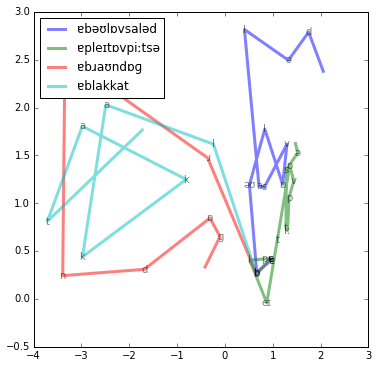

In [48]:
trace(["A bowl of salad","A plate of pizza","A brown dog", "A black cat"])

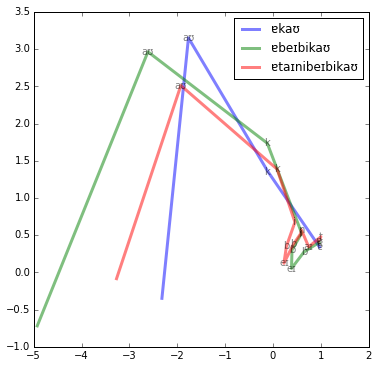

In [49]:
trace(["a cow", "a baby cow","a tiny baby cow"])

(0.0, 1.6000000000000001, -0.5, 4.0)

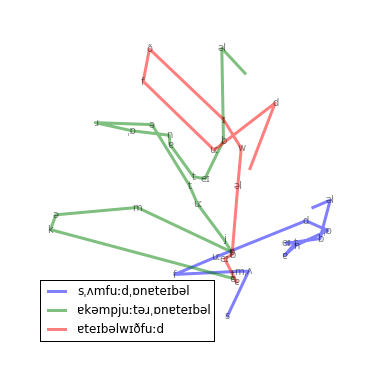

In [50]:
trace(["some food on a table","a computer on a table","a table with food"])
pylab.axis('off')

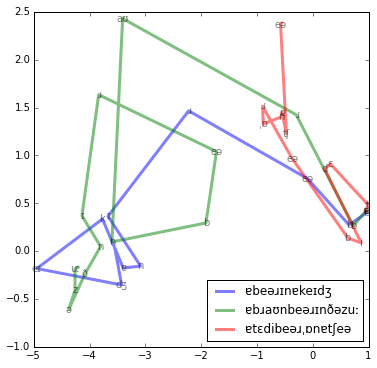

In [51]:
trace(["a bear in a cage", "a brown bear in the zoo","a teddy bear on a chair"])